#Question 2 part 1

In [3]:
!pip install wandb onnx -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00


In [4]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision
import time
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import wandb
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from torchvision import transforms


import torchvision.models as models
from torch.nn import CrossEntropyLoss
from torch.optim import Adam


In [5]:
wandb.login()
#05295dd19a5b535a27611bf3695f3b8b9eb13e22

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 41


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
# class_labels = {'amur_leopard': 0, 'amur_tiger': 1, 'birds': 2, 'black_bear': 3, 'brown_bear':4,
#                 'dog': 5, 'roe_deer': 6, 'sika_deer': 7, 'wild_boar': 8, 'people': 9}

# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, root, class_labels, train=True, transform=None):
#         self.root = root
#         self.class_labels = class_labels
#         self.transform = transform

#         # Create a list to hold the image file paths and labels
#         self.data = []
#         self.labels = []

#         # Load data and labels

#         classes = os.listdir(root)
#         for class_folder in classes:
#             folder = os.path.join(root, class_folder)
#             lim = 0
#             for image_file in os.listdir(folder):
#                 if image_file.lower().endswith('.jpg'):
#                     self.data.append(os.path.join(folder, image_file))
#                     self.labels.append(class_labels[class_folder])
#                     #lim += 1
#                     #if lim >= 50:
#                         #break

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         image_path = self.data[idx]
#         label = self.labels[idx]

#         # Open the image file
#         image = Image.open(image_path).convert('RGB')

#         # Transform the image if a transform is provided
#         if self.transform:
#             image = self.transform(image)

#         return image, label

#     def set_data(self, data, labels):
#         self.data = data
#         self.labels = labels

class_labels = {'amur_leopard': 0, 'amur_tiger': 1, 'birds': 2, 'black_bear': 3, 'brown_bear':4,
                'dog': 5, 'roe_deer': 6, 'sika_deer': 7, 'wild_boar': 8, 'people': 9}

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, class_labels, train=True, transform=None):
        self.root = root
        self.class_labels = class_labels
        self.transform = transform

        # Create a list to hold the image file paths and labels
        self.data = []
        self.labels = []

        # Load data and labels

        classes = os.listdir(root)
        for class_folder in classes:
            folder = os.path.join(root, class_folder)
            #lim = 0
            for image_file in os.listdir(folder):
                if image_file.lower().endswith('.jpg'):
                    image = Image.open(os.path.join(folder, image_file)).convert('RGB')
                    if self.transform:
                        image = self.transform(image)
                self.data.append(image)
                self.labels.append(class_labels[class_folder])
                    #lim += 1
                    #if lim >= 50:
                        #break

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        return image, label

    def set_data(self, data, labels):
        self.data = data
        self.labels = labels



root = 'drive/MyDrive/CV_HW1/Cropped_final'
resize_transformation = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
dataset = CustomDataset(root, class_labels=class_labels, train=True, transform=resize_transformation)


In [ ]:
wandb.init(project='cv_hw1_q2', entity='akanksha_singal')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [9]:
train_size = 0.7
val_size = 0.1
test_size = 0.2

train_idx, test_idx = train_test_split(
    range(len(dataset)),
    test_size=val_size + test_size,
    stratify=dataset.labels,
    random_state=42
)

train_data = torch.utils.data.Subset(dataset, train_idx)
test_val_dataset = torch.utils.data.Subset(dataset, test_idx)

val_size_actual = val_size / (val_size + test_size)
val_idx, test_idx = train_test_split(
    range(len(test_val_dataset)),
    test_size=val_size_actual,
    stratify=[test_val_dataset[i][1] for i in range(len(test_val_dataset))],
    random_state=42
)

val_data = torch.utils.data.Subset(test_val_dataset, val_idx)
test_data = torch.utils.data.Subset(test_val_dataset, test_idx)


In [10]:
BATCH_SIZE = 64
train_data = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True)
val_data = torch.utils.data.DataLoader(val_data, batch_size = BATCH_SIZE, shuffle=False)
test_data = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=False)

In [11]:

train_labels = [dataset.labels[idx] for idx in train_idx]

val_labels = [test_val_dataset.dataset.labels[test_val_dataset.indices[i]] for i in val_idx]


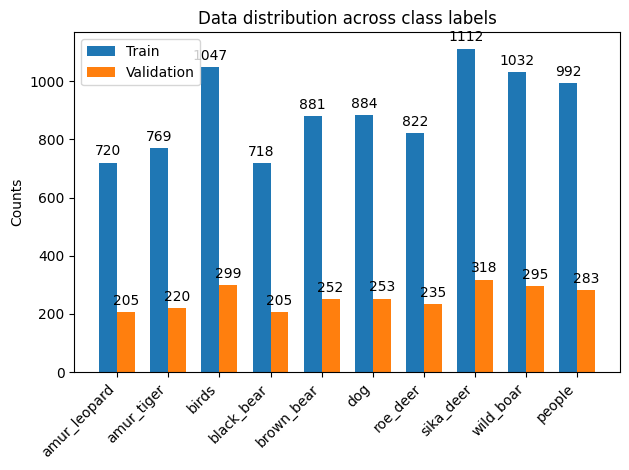

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

class_labels = {'amur_leopard': 0, 'amur_tiger': 1, 'birds': 2, 'black_bear': 3, 'brown_bear': 4,
                'dog': 5, 'roe_deer': 6, 'sika_deer': 7, 'wild_boar': 8, 'people': 9}


train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)


sorted_train_counts = [train_label_counts[class_labels[key]] for key in class_labels]
sorted_val_counts = [val_label_counts[class_labels[key]] for key in class_labels]


fig, ax = plt.subplots()

class_names = list(class_labels.keys())
x = np.arange(len(class_names))
width = 0.35

rects1 = ax.bar(x - width/2, sorted_train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, sorted_val_counts, width, label='Validation')

ax.set_ylabel('Counts')
ax.set_title('Data distribution across class labels')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


#Question 2 Part 2

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(8192, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
config = wandb.config
config.learning_rate = 0.001

In [ ]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_data, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_data)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy})


    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_data:
            images, labels = data[0], data[1]
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_data)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy})
    print(f"train_loss: {train_loss}, train_accuracy: {train_accuracy}, val_loss: {val_loss}, val_accuracy: {val_accuracy}")

print('Finished Training')

train_loss: 1.8760965310089976, train_accuracy: 0.32661245404923694, val_loss: 1.5948423408880466, val_accuracy: 0.4346978557504873
train_loss: 1.3939506339688672, train_accuracy: 0.5242285841595188, val_loss: 1.303205809942106, val_accuracy: 0.5567251461988304
train_loss: 1.1713923110184095, train_accuracy: 0.6061044892503064, val_loss: 1.2840603560936161, val_accuracy: 0.5695906432748538
train_loss: 1.0257152619091332, train_accuracy: 0.6640302996546731, val_loss: 1.1599180640243902, val_accuracy: 0.6167641325536063
train_loss: 0.8864061730973264, train_accuracy: 0.7084772195611005, val_loss: 1.2117108615433299, val_accuracy: 0.6163742690058479
train_loss: 0.7833375941354332, train_accuracy: 0.7420073521220898, val_loss: 1.0707852796810429, val_accuracy: 0.6647173489278753
train_loss: 0.6789163171399569, train_accuracy: 0.7726411941628606, val_loss: 1.0851953574797002, val_accuracy: 0.6565302144249513
train_loss: 0.5821639899666428, train_accuracy: 0.804945973042219, val_loss: 1.1581

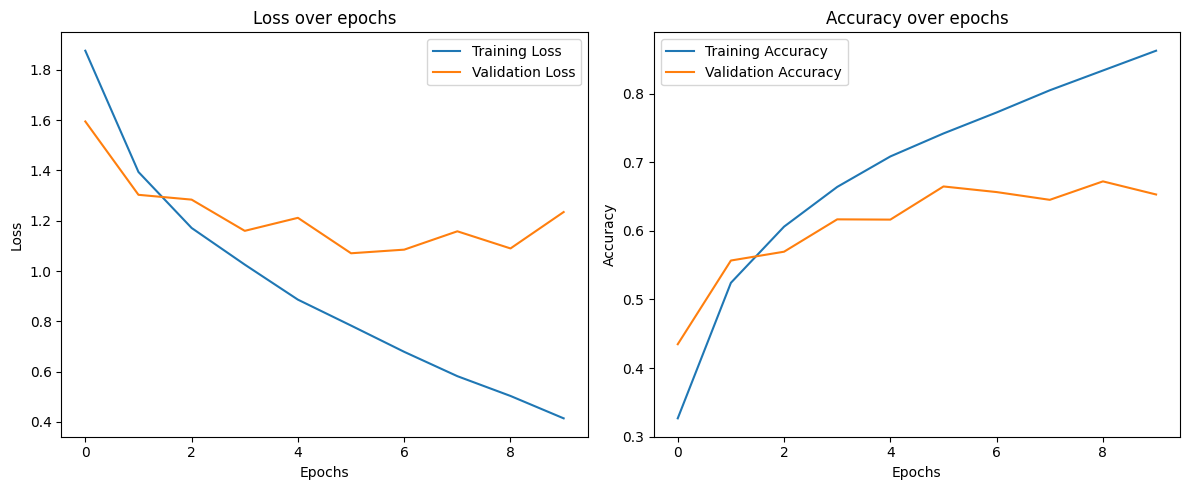

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

c. There is some difference between the training and validation loss i.e Training loss is lower than validation loss. We can see these losses are diverging we can say that the model is overfitting.

In [ ]:
model.eval()

true_labels = []
pred_labels = []


with torch.no_grad():
    for data in test_data:
        inputs, labels = data[0], data[1]
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())


true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1-Score: {f1}")

Accuracy: 0.6328916601714731
F1-Score: 0.6341451503964205


d. Accuracy is 52.9% on test dataset
and F1 score is 0.520

In [ ]:

conf_mat = confusion_matrix(true_labels, pred_labels)
print(conf_mat)

wandb.log({"test_accuracy": accuracy, "test_f1_score": f1, "confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=true_labels, preds=pred_labels, class_names=list(class_labels.keys()))})


[[ 71  10   6   0   1   2   2   9   1   1]
 [ 15  59   7   0   2   6   4  11   3   3]
 [  2   1 110   3   4   3   2  15   6   4]
 [  5   2   0  51  13   4   2   5  20   0]
 [  7   0   0  18  75   4   3   6  13   0]
 [  4   3   8   1   7  68   6  22   6   1]
 [  1   4   1   0   1   8  69  24   8   1]
 [  2   5  12   1   4   7  14 104   9   1]
 [  2   5   4   2   8   1   6  11 108   1]
 [  6   1  18   1   1   6   2   9   1  97]]


In [ ]:
wandb.finish()

test_accuracy,▁
test_f1_score,▁
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▅▅▆▆██▇█▇
val_loss,█▄▄▂▃▁▁▂▁▃
test_accuracy,0.63289
test_f1_score,0.63415
train_accuracy,0.86265
train_loss,0.4145
val_accuracy,0.65302


#Qestion 2 Part 3

In [ ]:
wandb.init(project="resnet-finetune", entity="akanksha_singal")

wandb: Currently logged in as: akanksha21008 (akanksha_singal). Use `wandb login --relogin` to force relogin


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

class FineTunedResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(FineTunedResNet18, self).__init__()

        self.resnet18 = models.resnet18(pretrained=True)

        self.features = nn.Sequential(*list(self.resnet18.children())[:-1])

        num_ftrs = self.resnet18.fc.in_features

        self.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):

        x = self.features(x)

        x = torch.flatten(x, 1)

        classification = self.fc(x)
        return classification, x


config = wandb.config
config.learning_rate = 0.001
model = FineTunedResNet18(num_classes=10)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=config.learning_rate)


num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total = 0

    for images, labels in train_data:
        images.size()
        optimizer.zero_grad()

        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_data)
    train_accuracy = correct_preds / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy})


    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_data:
            images.size()

            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_data)
    val_accuracy = correct_preds / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy})
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")



Epoch 1/10, Train Loss: 0.9084, Train Accuracy: 0.6892, Val Loss: 0.9101, Val Accuracy: 0.6940
Epoch 2/10, Train Loss: 0.5735, Train Accuracy: 0.8054, Val Loss: 0.9743, Val Accuracy: 0.7248
Epoch 3/10, Train Loss: 0.3959, Train Accuracy: 0.8661, Val Loss: 0.7057, Val Accuracy: 0.7887
Epoch 4/10, Train Loss: 0.3096, Train Accuracy: 0.8971, Val Loss: 0.6656, Val Accuracy: 0.7926
Epoch 5/10, Train Loss: 0.2305, Train Accuracy: 0.9219, Val Loss: 0.6856, Val Accuracy: 0.7899
Epoch 6/10, Train Loss: 0.1983, Train Accuracy: 0.9363, Val Loss: 0.6192, Val Accuracy: 0.8230
Epoch 7/10, Train Loss: 0.1555, Train Accuracy: 0.9479, Val Loss: 0.9114, Val Accuracy: 0.7704
Epoch 8/10, Train Loss: 0.1563, Train Accuracy: 0.9486, Val Loss: 0.5604, Val Accuracy: 0.8402
Epoch 9/10, Train Loss: 0.1152, Train Accuracy: 0.9635, Val Loss: 0.6677, Val Accuracy: 0.8288
Epoch 10/10, Train Loss: 0.0813, Train Accuracy: 0.9725, Val Loss: 0.6608, Val Accuracy: 0.8363


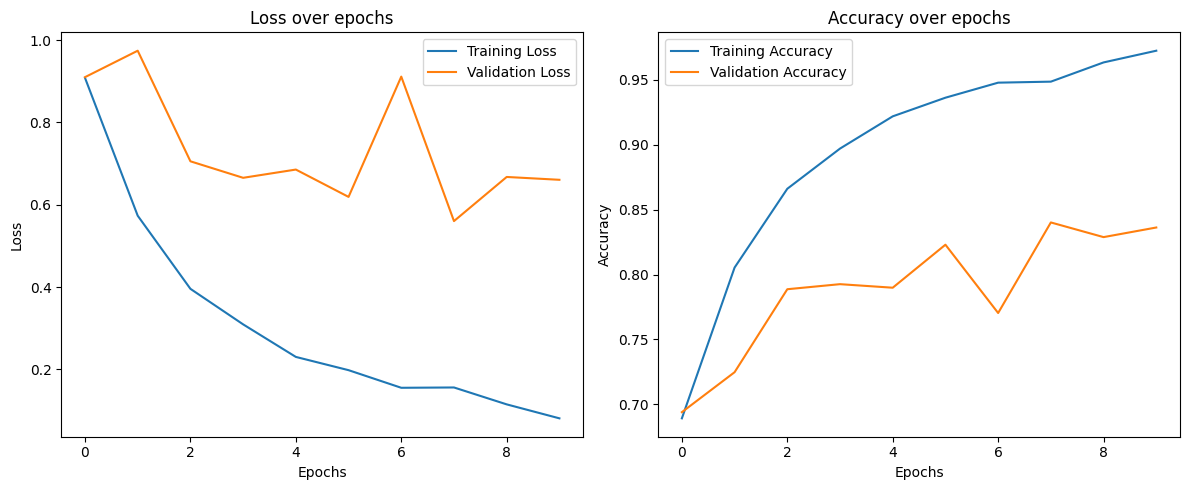

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()

true_labels = []
pred_labels = []


with torch.no_grad():
    for data in test_data:
        inputs, labels = data[0], data[1]
        outputs, _ = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())


true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1-Score: {f1}")

Accuracy: 0.8425565081839439
F1-Score: 0.8422363733672474


In [ ]:

conf_mat = confusion_matrix(true_labels, pred_labels)
print(conf_mat)
b
wandb.log({"test_accuracy": accuracy, "test_f1_score": f1, "confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=true_labels, preds=pred_labels, class_names=list(class_labels.keys()))})


[[ 92   0   5   0   2   0   0   2   1   1]
 [  2  91   1   0   2   8   1   3   2   0]
 [  0   0 143   0   2   3   0   0   2   0]
 [  0   0   2  58  29   7   0   0   6   0]
 [  0   0   1   6 105   4   1   2   7   0]
 [  0   1   4   1   0 114   0   0   5   1]
 [  0   0   1   0   0   9  93   9   5   0]
 [  0   0   6   1   1   8   4 127  11   1]
 [  0   1   2   5   0   0   1   2 136   1]
 [  0   0   8   1   1   7   1   1   1 122]]


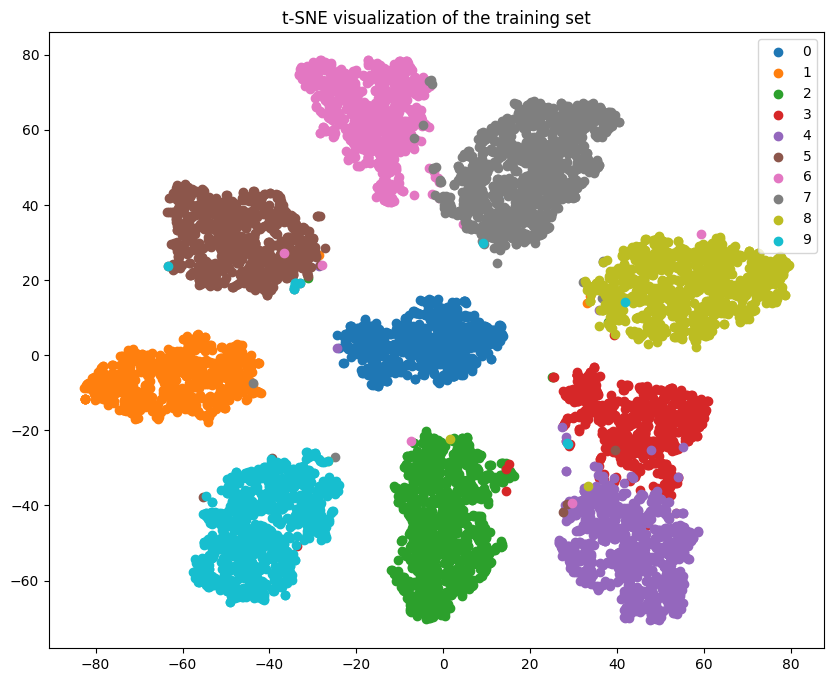

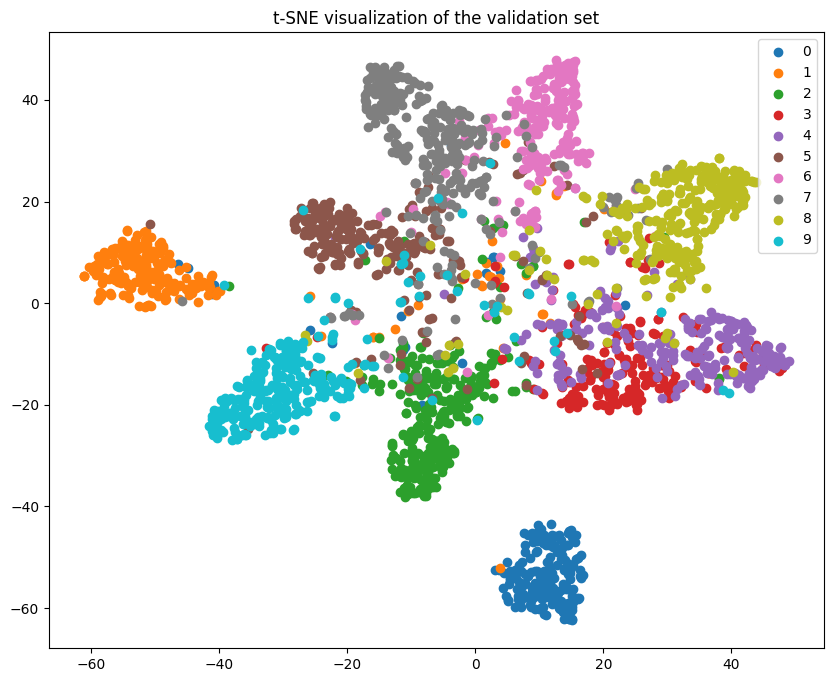

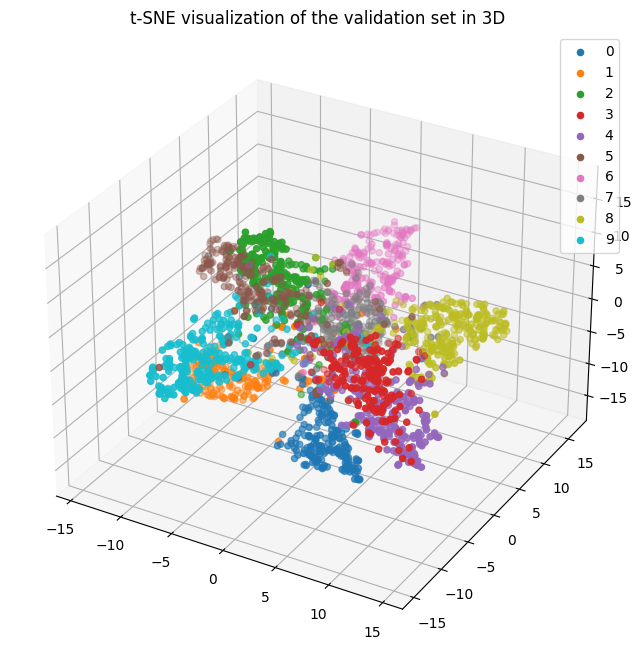

In [ ]:
model.eval()


def extract_features(dataloader, model):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            outputs, _ = model(inputs)
            features.append(outputs)
            labels.append(label)
    features = torch.cat(features)
    labels = torch.cat(labels)
    return features.numpy(), labels.numpy()


train_features, train_labels = extract_features(train_data, model)
val_features, val_labels = extract_features(val_data, model)
test_features, test_labels = extract_features(test_data, model)


tsne = TSNE(n_components=2, random_state=123)
train_tsne_features = tsne.fit_transform(train_features)
val_tsne_features = tsne.fit_transform(val_features)

plt.figure(figsize=(10, 8))
for label in set(train_labels):
    indices = train_labels == label
    plt.scatter(train_tsne_features[indices, 0], train_tsne_features[indices, 1], label=label)
plt.legend()
plt.title('t-SNE visualization of the training set')
plt.show()

plt.figure(figsize=(10, 8))
for label in set(val_labels):
    indices = val_labels == label
    plt.scatter(val_tsne_features[indices, 0], val_tsne_features[indices, 1], label=label)
plt.legend()
plt.title('t-SNE visualization of the validation set')
plt.show()


tsne = TSNE(n_components=3, random_state=123)
val_tsne_features = tsne.fit_transform(val_features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for label in set(val_labels):
    indices = val_labels == label
    ax.scatter(val_tsne_features[indices, 0], val_tsne_features[indices, 1], val_tsne_features[indices, 2], label=label)
plt.legend()
plt.title('t-SNE visualization of the validation set in 3D')
plt.show()

In [ ]:
wandb.finish()

test_accuracy,▁
test_f1_score,▁
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▂▆▆▆▇▅█▇█
val_loss,▇█▃▃▃▂▇▁▃▃
test_accuracy,0.84256
test_f1_score,0.84224
train_accuracy,0.97249
train_loss,0.0813
val_accuracy,0.83626


In [12]:
wandb.init(project="resnet-data-aug", entity="akanksha_singal")

wandb: Currently logged in as: akanksha21008 (akanksha_singal). Use `wandb login --relogin` to force relogin


In [13]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Rotates by +/- 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming 3-channel images
])

aug_dataset = CustomDataset(root, class_labels=class_labels, train=True, transform=train_transforms)

train_size = 0.7
val_size = 0.1
test_size = 0.2

train_idx, test_idx = train_test_split(
    range(len(dataset)),
    test_size=val_size + test_size,
    stratify=dataset.labels,
    random_state=42
)

train_data = torch.utils.data.Subset(aug_dataset, train_idx)
BATCH_SIZE = 64
train_data = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True)

In [14]:
train_labels = [aug_dataset.labels[idx] for idx in train_idx]

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

class FineTunedResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(FineTunedResNet18, self).__init__()

        self.resnet18 = models.resnet18(pretrained=True)

        self.features = nn.Sequential(*list(self.resnet18.children())[:-1])

        num_ftrs = self.resnet18.fc.in_features

        self.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):

        x = self.features(x)

        x = torch.flatten(x, 1)

        classification = self.fc(x)
        return classification, x


config = wandb.config
config.learning_rate = 0.001
model = FineTunedResNet18(num_classes=10)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=config.learning_rate)


num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total = 0

    for images, labels in train_data:
        images.size()
        optimizer.zero_grad()

        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_data)
    train_accuracy = correct_preds / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy})


    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_data:
            images.size()

            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_data)
    val_accuracy = correct_preds / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy})
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.6MB/s]


Epoch 1/10, Train Loss: 1.0333, Train Accuracy: 0.6472, Val Loss: 1.1162, Val Accuracy: 0.6425
Epoch 2/10, Train Loss: 0.6627, Train Accuracy: 0.7706, Val Loss: 0.7992, Val Accuracy: 0.7185
Epoch 3/10, Train Loss: 0.4896, Train Accuracy: 0.8291, Val Loss: 1.0741, Val Accuracy: 0.6850
Epoch 4/10, Train Loss: 0.3796, Train Accuracy: 0.8694, Val Loss: 0.7675, Val Accuracy: 0.7622
Epoch 5/10, Train Loss: 0.3022, Train Accuracy: 0.9002, Val Loss: 1.0106, Val Accuracy: 0.7014
Epoch 6/10, Train Loss: 0.2280, Train Accuracy: 0.9210, Val Loss: 0.9349, Val Accuracy: 0.7680
Epoch 7/10, Train Loss: 0.1950, Train Accuracy: 0.9339, Val Loss: 0.7518, Val Accuracy: 0.8008
Epoch 8/10, Train Loss: 0.1912, Train Accuracy: 0.9359, Val Loss: 0.8891, Val Accuracy: 0.7676
Epoch 9/10, Train Loss: 0.1373, Train Accuracy: 0.9557, Val Loss: 0.8558, Val Accuracy: 0.7887
Epoch 10/10, Train Loss: 0.0947, Train Accuracy: 0.9691, Val Loss: 1.0444, Val Accuracy: 0.7548


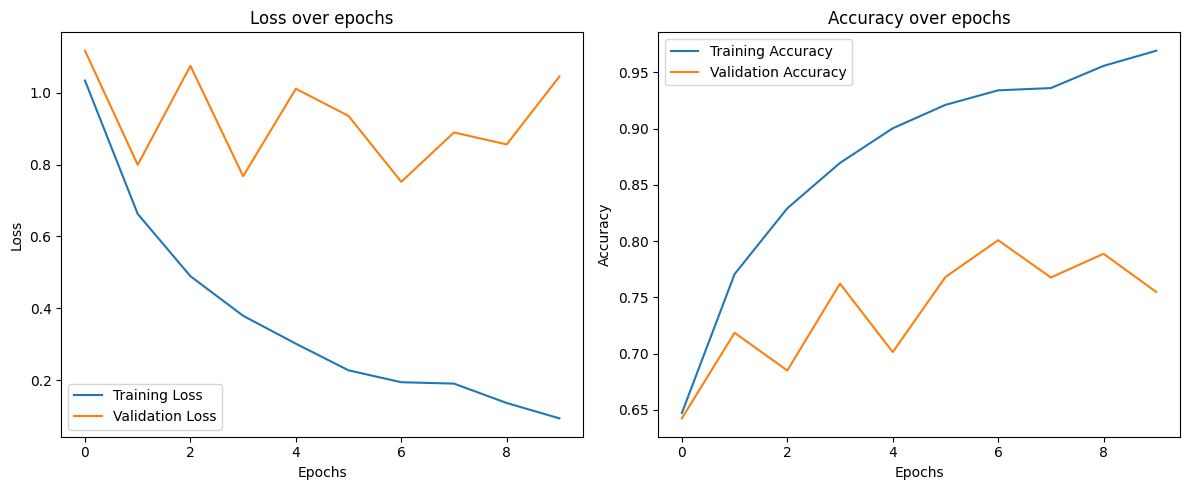

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for data in test_data:
        inputs, labels = data[0], data[1]
        outputs, _ = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1-Score: {f1}")

Accuracy: 0.7435697583787997
F1-Score: 0.7487109806541541


In [18]:

conf_mat = confusion_matrix(true_labels, pred_labels)
print(conf_mat)

wandb.log({"test_accuracy": accuracy, "test_f1_score": f1, "confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=true_labels, preds=pred_labels, class_names=list(class_labels.keys()))})


[[ 88   0   1   0   0   0   1   8   1   4]
 [  0  85   0   0   1   4   1  11   1   7]
 [  0   0  92   3   1   4   0  14   3  33]
 [  0   0   0  69  18   2   0   5   4   4]
 [  0   0   1  34  76   0   1   8   2   4]
 [  0   0   2   1   0  79   1  22   7  14]
 [  0   0   0   0   0   4  82  29   1   1]
 [  0   0   0   2   1   1   1 136   6  12]
 [  0   1   0   4   7   4   0   8 115   9]
 [  0   1   0   1   1   2   1   4   0 132]]


In [19]:
wandb.finish()

test_accuracy,▁
test_f1_score,▁
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▃▆▄▇█▇▇▆
val_loss,█▂▇▁▆▅▁▄▃▇
test_accuracy,0.74357
test_f1_score,0.74871
train_accuracy,0.96914
train_loss,0.09466
val_accuracy,0.75478
